In [1]:
# Import some libraries
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.patheffects as PathEffects
from adjustText import adjust_text

In [2]:
# Load the file with all the mutation data and the database mutations with our defined categories
mutationfile = pd.read_csv("../Data/Structure_data/FH_complete_mutation_summary.csv")
database_mutations = pd.read_csv("../Data/Mutations_database/FH_mutations_missense_categories.csv")

## Assigning tags to the mutations based on known/unknown and predictions

In [3]:
# Get the known benign and LOF
known_LOF = database_mutations[database_mutations["Category"] == "LOF"]
known_benign = database_mutations[database_mutations["Category"] == "Benign"]

In [4]:
#Get sets of the mutations
known_LOF_set = set(known_LOF["Mutation"])
known_benign_set = set(known_benign["Mutation"])

In [5]:
# Apply a label to the known LOF and benign mutations
known_LOF["Type"] = "LOF"
known_benign["Type"] = "benign"

/home/ds728/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/ds728/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [6]:
# Merge the known LOF and benignso we have one array containing all known mutations
merged_known_mutations = pd.concat([known_LOF, known_benign])
merged_known_mutations = merged_known_mutations.drop_duplicates(subset = "Protein Change")
merged_known_mutations = merged_known_mutations[["Type", "Mutation"]]

In [7]:
# Merge the known mutations with the unknown - add a tag to the mutations we dont have a "ground truth" for
mutations_type = pd.merge(mutationfile, merged_known_mutations, left_on = "Mutation", right_on = "Mutation", how = "outer")
mutations_type.fillna('unknown', inplace=True)

In [8]:
#Classifiy every mutation with a tag for buried, bindingsite, hingesite and destabilizing
mutations_type["Buried"] = mutations_type["RSA"].apply(lambda x: True if x <= 0.2 else False)
mutations_type["bindingsite"] = mutations_type["Mindist_bindingsiteA"].apply(lambda x: True if x <= 6 else False)
mutations_type["hingesite"] = mutations_type["Mindist_hinge"].apply(lambda x: True if x <= 6 else False)
mutations_type["destabilizing"] = mutations_type.apply(lambda x: True if ((x["Buried"] == True) & (x["average_energy"] >= 2.5)) else False, axis = 1)

In [9]:
# Have an array with every possible mutation, with tags for whether it is known or not, and what our prediction for it is
mutations_type.head()

,Unnamed: 0,Residue,AAfrom,AAto,rhapsodyscore,rhapsodyclass,polyphenscore,polyphenclass,Foldx_energy,Rosetta_energy,Mutation,average_energy,RSA,Mindist_bindingsiteA,Mindist_hinge,Type,Buried,bindingsite,hingesite,destabilizing
0,0,49,S,A,0.086,neutral,0.00,neutral,0.061363,3.265,S49A,1.663182,0.992308,23.461148,33.7131,unknown,False,False,False,False
1,1,49,S,C,0.535,neutral,0.86,deleterious,0.067352,7.990,S49C,4.028676,0.992308,23.461148,33.7131,unknown,False,False,False,False
2,2,49,S,D,0.052,neutral,0.00,neutral,-0.103203,1.891,S49D,0.893899,0.992308,23.461148,33.7131,unknown,False,False,False,False
3,3,49,S,E,0.049,neutral,0.00,neutral,-0.086741,0.983,S49E,0.448129,0.992308,23.461148,33.7131,unknown,False,False,False,False
4,4,49,S,F,0.529,neutral,0.62,deleterious,0.182080,4.837,S49F,2.509540,0.992308,23.461148,33.7131,unknown,False,False,False,False


In [10]:
# Assign a category to each mutation based on what we predict it to do - bindingsite > hingesite > destabilizing
mutation_class = []
for item1, item2 in mutations_type.iterrows():
    if item2["Type"] == "benign":
        category = "benign"
    elif item2["bindingsite"] == True:
        category = "bindingsite"
    elif item2["hingesite"] == True:
        category = "hingesite"
    elif item2["destabilizing"] == True:
        category = "destabilizing"
    else:
        category = "unknown"
    mutation_class.append(category)

In [11]:
# add this prediction to the array as a column
mutations_type["prediction"] = mutation_class

#### We now have an array with our prediction for each mutation

## Generate the umap

In [12]:
# Make an array with the data we will feed into the umap
mutations_type_umapvalues = mutations_type[["average_energy", "Mindist_bindingsiteA", "Mindist_hinge", "RSA"]]

In [13]:
import umap
seed = 1111

In [14]:
# Run the umap - these are fairly standard parameters, I had to play a bit to get a good spread of points (n_epochs and min_dist)
embedding = umap.UMAP(n_neighbors=100,
                      min_dist=0.5,
                      n_epochs=1000,
                      metric='correlation',
                      random_state = seed).fit_transform(mutations_type_umapvalues)

In [15]:
# Convert the umap values to a dataframe and add to the mutation array - now each mutation has a umap coordinate
umap_df = pd.DataFrame(embedding, columns=["Umap1", "Umap2"])
mutations_umap = pd.concat([mutations_type, umap_df], axis =1)

## Subset the array into correctly and incorrectly predicted mutations

In [16]:
# Get the mutations we have a ground truth for
mutations_known = mutations_umap[mutations_umap["Type"] != "unknown"]

In [17]:
# Get the mutations with predict correctly and incorrectly (we have to split to benign and non-benign due to the way I assigned the labels earlier)
mutations_predicted_correctly = mutations_known[mutations_known["prediction"] != "unknown"]
mutations_predicted_correctly = mutations_predicted_correctly[mutations_predicted_correctly["prediction"] != "benign"]
mutations_predicted_incorrectly = mutations_known[mutations_known["prediction"] == "unknown"]

benign_only = mutations_known[mutations_known["Type"] == "benign"]
benign_incorrect =benign_only[benign_only["destabilizing"] == True] 
benign_correct =benign_only[benign_only["destabilizing"] != True] 

### Split into the categories we will colour/alter shape by

In [18]:
# Merge to a single array of the incorrect classifications
incorrect_classifications = pd.concat([mutations_predicted_incorrectly, benign_incorrect])
correct_classifications = pd.concat([mutations_predicted_correctly, benign_correct])

In [20]:
mutations_umap_destab = mutations_umap[mutations_umap["prediction"] == "destabilizing"]
mutations_umap_unknown = mutations_umap[mutations_umap["prediction"] == "unknown"]
mutations_umap_hingesite = mutations_umap[mutations_umap["prediction"] == "hingesite"]
mutations_umap_bindingsite = mutations_umap[mutations_umap["prediction"] == "bindingsite"]
#mutations_umap_LOF = mutations_umap[mutations_umap["Type"] == "LOF"]
#mutations_umap_benign = mutations_umap[mutations_umap["category"] == "benign"]

In [21]:
plt.rcParams['figure.figsize'] = [14, 14]

In [22]:
# Define our color sceheme
colour_dict = dict({"benign":"k", "destabilizing":"#FB7D8c", "unknown":"#656565", "bindingsite":"#43A9DB", "hingesite":"#FFA945"})

In [23]:
# Define the marker styles
markers = {"LOF": "o", "benign": "^"}

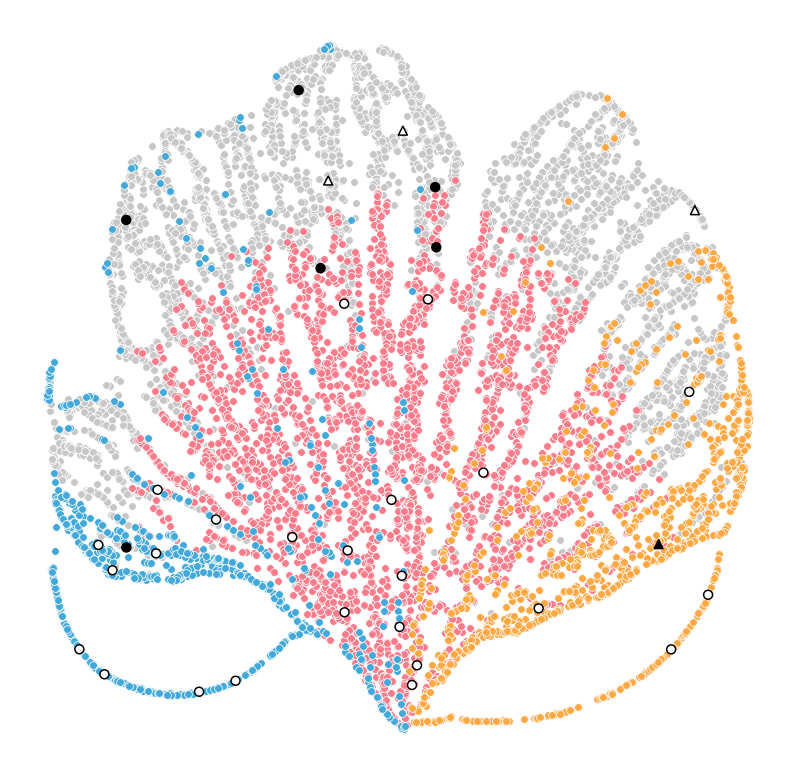

In [24]:
# Plot the "base" regions of the plot - plot the unknown first, then overlay the destabilizing, hinge, and benign
ax = sns.scatterplot(mutations_umap_destab["Umap1"], mutations_umap_destab["Umap2"], color = "#FB7D8C", zorder =2,s = 60)
ax = sns.scatterplot(mutations_umap_unknown["Umap1"], mutations_umap_unknown["Umap2"], color = "#c7c7c7", zorder =1,s = 60)
ax = sns.scatterplot(mutations_umap_hingesite["Umap1"], mutations_umap_hingesite["Umap2"], color = "#FFA945", zorder =4,s = 60)
ax = sns.scatterplot(mutations_umap_bindingsite["Umap1"], mutations_umap_bindingsite["Umap2"], color = "#43A9DB", zorder =5,s = 60)

# overlay the mutations with known properties - circle = LOF, triangle = benign, white = correctly predicted, black = incorrectly predicted
ax = sns.scatterplot(correct_classifications["Umap1"], correct_classifications["Umap2"], color = "white", edgecolor = "k",linewidth = 1.5, zorder =8, s = 80, style = correct_classifications["Type"], markers = markers, legend = False)
ax = sns.scatterplot(incorrect_classifications["Umap1"], incorrect_classifications["Umap2"], color = "k", edgecolor = "k",linewidth = 1.5, zorder =8, s = 80, style = incorrect_classifications["Type"], markers = markers, legend = False)

# Remove labels as they arent informative for umap
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
sns.despine(left = True, bottom = True)
# Invert the y axis because I think it looks nicer
plt.gca().invert_yaxis()


plt.savefig("Figure_6_A_umap_mutational_landscape.png", dpi = 600)